<a href="https://colab.research.google.com/github/LucaBarco/TesinaDataSpaces/blob/main/Tesina_s276072.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
# scientific computing libaries
import pandas as pd
import numpy as np
from sklearn import preprocessing
#plots
import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt

# data mining libaries
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA#, FastICA
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, learning_curve
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, plot_confusion_matrix

from imblearn.pipeline import make_pipeline, Pipeline

from imblearn.over_sampling import SMOTE

SEED=37

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



# Loading dataset

The cardiovascular diseases are one of the most frequent causes of death.  They mainly causes heart failures: the hearthcannot pump enough blood to satisfy the needs of the body.  Nowadays, the electronic medical records can help in findingcorrelations between symptoms and body values, and applying machine learning algorithms can help to predict the patient’ssurvival and to highlight the most important features to take in consideration.This tesina is based on the dataset used in the work of Chicco and Jurman  [1] "Machine learning can predict survival ofpatients with heart failure from serum creatinine and ejection fraction alone".

The dataset contains the medical records of 299 patients with an hearth failure gathered in Pakistan during 2015. 
The dataset contains 13 features which report clinical, body and lifestyle data:

- *age*: age of the patient (years)
- *anaemia*: decrease of red blood cells or hemoglobin (boolean)
- *high_blood_pressure*: if the patient has hypertension (boolean)
- *creatinine_phosphokinase* (CPK): level of the CPK enzyme in the blood (mcg/L)
- *diabetes*: if the patient has diabetes (boolean)
- *ejection_fraction*: percentage of blood leaving the heart at each contraction (percentage)
- *platelets*: platelets in the blood (kiloplatelets/mL)
- *sex*: woman or man (binary)
- *serum_creatinine*: level of serum creatinine in the blood (mg/dL)
- *serum_sodium*: level of serum sodium in the blood (mEq/L)
- *smoking*: if the patient smokes or not (boolean)
- *time*: follow-up period (days)
- ***death_event***: if the patient deceased during the follow-up period (boolean)

In [2]:
# Clone github repository with dataset
! rm -r 'TesinaDataSpaces'
if not os.path.isdir('./TesinaDataSpaces'):
  !git clone https://github.com/LucaBarco/TesinaDataSpaces

datasetPath='./TesinaDataSpaces/Dataset/heart_failure_clinical_records_dataset.csv'

ds = pd.read_csv(datasetPath)

print("The dataset has %d rows and %d columns." % ds.shape)

#Check for null values
print("Checking for null values....", end="")
print(("SOME" if ds.isnull().values.any() else "NO")  + " null/missing values.")

#Show the first rows
print("\nFirst 5 rows:")
ds.head(5)

Cloning into 'TesinaDataSpaces'...
remote: Enumerating objects: 132, done.
remote: Counting objects: 100% (132/132), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 132 (delta 22), reused 108 (delta 11), pack-reused 0
Receiving objects: 100% (132/132), 5.67 MiB | 7.50 MiB/s, done.
Resolving deltas: 100% (22/22), done.
The dataset has 299 rows and 13 columns.
Checking for null values....NO null/missing values.

First 5 rows:


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


Let's have a look to the description of the features given by the function describe() of pandas

In [3]:
ds.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


We can see that there are a lot of boolean features for which these statistics have not much sense (anaemia, diabetes, sex, smoking).
There are, instead, features with interesting properites.

In [4]:
#divide the dataset in 2 sub datasets: one containing death events and one other containing no death events

death = ds[ds["DEATH_EVENT"] == 1]
no_death = ds[ds["DEATH_EVENT"] == 0]

colors = plotly.colors.DEFAULT_PLOTLY_COLORS

##Features: charts and box plots

Let's see the charts of death events considering all features:


In [5]:
def add_trace(fig, col, visible=False):
  fig.add_trace(go.Histogram(
        x=death[col],
        name='death',
        marker = dict(color = colors[3]),
        visible=visible))

  fig.add_trace(go.Histogram(
        x=no_death[col],
        name='no death',
        marker = dict(color = colors[2]),
        visible = visible))

#If you want dropdown or not set this flag
dropdown=True

fig2 = go.Figure()

excluded_features = ["DEATH_EVENT"]
features_for_charts = [x for x in ds.columns if x not in excluded_features]

menulist=[]

for feat,i  in zip(features_for_charts, range(len(features_for_charts))):
  add_trace(fig2, feat, True if feat == "age" else False)
  flagList=[False]*(2*i)+[True]*2+[False]*(2*(len(features_for_charts)-i+1))
  menulist.append(
      dict(label=feat,
          method="update",
          args=[{"visible": flagList
                }, {"title":feat}
                ]))

fig2.update_layout(updatemenus=[
                               dict(active=0,
                                    buttons=menulist,
                                    type ="dropdown" if dropdown else "buttons", 
                                    direction="down" if dropdown else "left", 
                                    pad={"r": 8, "t": 8},
                                    showactive=True,
                                    x=0.5 if dropdown else 0, 
                                    xanchor="left",
                                    y=1.15,
                                    yanchor="top")])

fig2.update_layout(title_text=features_for_charts[0], font=dict(size=18))
fig2.show()

To well compare the datta distributions we have to draw the box plots. 
A box plot is a plot that helps in visualizing the data distributions.
It shows:
- the *median* of the data: it's shown by the line that divides the box in two parts.
- the *lower quartile* (Q1, the 25% of the data fall below this value) and the *upper quartile* (Q3,   the 75% of the data fall below this value), and they are used to compute the *interquartile range* IRQ.
- the *lower fence*: Q1-1.5*IQR
- the *upper fence*: Q3+1.5*IQR
- the *outliers*: the values that appear out of the lower and upper fences

This plot can help us in understanding how the data are distributed, if they are dispersed, if the distribution is symmetrical and so on.

In [6]:
onlyBox=True
exclude_binaries=True

In [7]:
def add_box_trace(fig, col, visible=False):
    fig.add_trace(go.Box(
          y=death[col],
          name='death',
          marker = dict(color = colors[3]),
          visible=visible))

    fig.add_trace(go.Box(
          y=no_death[col],
          name='no death',
          marker = dict(color = colors[2]),
          visible = visible))


def add_2_trace(fig, col, visible=False):
    fig.add_trace(go.Histogram(
          x=death[col],
          name='death distribution',
          marker = dict(color = colors[3]),
          visible=visible), row=1, col=1)

    fig.add_trace(go.Histogram(
          x=no_death[col],
          name='no death distribution',
          marker = dict(color = colors[2]),
          visible = visible), row=1, col=1)
    fig.add_trace(go.Box(
          y=death[col],
          name='death box',
          marker = dict(color = colors[3]),
          visible=visible), row=2, col=1)

    fig.add_trace(go.Box(
          y=no_death[col],
          name='no death box',
          marker = dict(color = colors[2]),
          visible = visible), row=2, col=1)
    

if onlyBox:
  
  #If you want dropdown or not set this flag
  dropdown=True

  fig3 = go.Figure()
  #remove binary features: for them the box plots are not significantly meaningful
  excluded_features = ["DEATH_EVENT"]
  if exclude_binaries:
    for feat in ds.columns:
      if len(ds[feat].unique()) < 5 and feat not in excluded_features:
        excluded_features.append(feat)
  print("Excluded features: ")
  print(excluded_features)
  features_for_charts = [x for x in ds.columns if x not in excluded_features]


  menulist=[]
  for feat,i  in zip(features_for_charts, range(len(features_for_charts))):
    add_box_trace(fig3, feat, True if feat == "age" else False)
    flagList=[False]*(2*i)+[True]*2+[False]*(2*(len(features_for_charts)-i+1))
    menulist.append(
        dict(label=feat,
            method="update",
            args=[{"visible": flagList
                  }, {"title":feat}
                  ]))

  fig3.update_layout(updatemenus=[
                                dict(active=0,
                                      buttons=menulist,
                                      type ="dropdown" if dropdown else "buttons", 
                                      direction="down" if dropdown else "left", 
                                      pad={"r": 8, "t": 8},
                                      showactive=True,
                                      x=0.5 if dropdown else 0, 
                                      xanchor="left",
                                      y=1.15,
                                      yanchor="top")])

  fig3.update_layout(title_text=features_for_charts[0], font=dict(size=18))
  fig3.show()

else:
    
  #If you want dropdown or not set this flag
  dropdown=True

  fig4 = make_subplots(rows=2, cols=1, start_cell="top-left",  subplot_titles=("Distribution", "Box plot"))

  #remove binary features: for them the box plots are not significantly meaningful
  excluded_features = ["DEATH_EVENT"]
  if exclude_binaries:
    for feat in ds.columns:
      if len(ds[feat].unique()) < 5 and feat not in excluded_features:
        excluded_features.append(feat)
  print("Excluded features: ")
  print(excluded_features)
  features_for_charts = [x for x in ds.columns if x not in excluded_features]


  menulist=[]
  for feat,i  in zip(features_for_charts, range(len(features_for_charts))):
    add_2_trace(fig4, feat, True if feat == "age" else False)
    flagList=[False]*(4*i)+[True]*4+[False]*(4*(len(features_for_charts)-i+1))
    menulist.append(
        dict(label=feat,
            method="update",
            args=[{"visible": flagList
                  }, {"title":feat}
                  ]))

  fig4.update_layout(updatemenus=[
                                dict(active=0,
                                      buttons=menulist,
                                      type ="dropdown" if dropdown else "buttons", 
                                      direction="down" if dropdown else "left", 
                                      pad={"r": 8, "t": 8},
                                      showactive=True,
                                      x=0.5 if dropdown else 0, 
                                      xanchor="left",
                                      y=1.15,
                                      yanchor="top")])

  fig4.update_layout(height=900, title_text=features_for_charts[0], font=dict(size=18))
  fig4.show()


Excluded features: 
['DEATH_EVENT', 'anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']


### Plots comparisons
### Age
- Mean: similar (65 vs 50)
- Interquartile ranges/ Box length: similar (20 vs 15)
- Spread/adjacent values: similar behaviour
- Symmetry: death box is symmetrical, the no death no. 
- Potential outliers: some in no death
The two distributions are similar. There is more dispersion in death data.

### Creatinine phosphokinase
- Mean: similar (259 vs 245)
- Interquartile ranges/ Box length: similar 
- Spread/adjacent values: similar behaviour
- Symmetry: both are asymmetrical 
- Potential outliers: too much
Too much outliers to say something meaningful.

### Ejection fraction
- Mean: 30 vs 38
- Interquartile ranges/ Box length: similar (13 vs 10)
- Spread/adjacent values: similar behaviour
- Symmetry: both asymmetrical, more unbalancing in the no death box. 
- Potential outliers: both; more in death box
Similar distributions but they are centered in different points.

### Platelets
- Mean: similar (259k vs 263k)
- Interquartile ranges/ Box length: no death double length than death
- Spread/adjacent values: similar behaviour
- Symmetry: similar, symmetrical 
- Potential outliers: both; more in no death box
Similar distributions, with some outliers.

### Serum creatinine
- Mean: similar (1.3 vs 1)
- Interquartile ranges/ Box length: 1 vs 0.3, more dispersion in death 
- Spread/adjacent values: death has more dispersion
- Symmetry: both are asymmetrical 
- Potential outliers: both, more in death
More dispersion in death box and more outliers.


### Serum sodium
- Mean: similar (135 vs 138)
- Interquartile ranges/ Box length: similar, 5 in both  
- Spread/adjacent values: death has more dispersion
- Symmetry: death is symmetrical, no death is asymmetrical 
- Potential outliers: both, more in no death
Similar distributions.

### Time
- Mean: (44 vs 173)
- Interquartile ranges/ Box length: 80 vs 118, more dispersion in no death 
- Spread/adjacent values: death has more dispersion
- Symmetry: both are asymmetrical in a dual way
- Potential outliers: death
Very different distributions: different means, opposite symmetry. For sure it will be a very important feature in order to do a prediction.

Looking to these charts, we can see that:
- *Age*: we observe similar trends for death and no death events. The interesting fact is that the older the patients, the higher the probability to have a death event. In particular, the proportion between death events and no death events is reversing after an age of 70. So, it means that the age is an important feature for our analysis, even if the distributions have not gaussian behaviours. Looking at the box plot, we can observe that the distributions are quite similar, there is more dispersion in the death distribution because there are death events for each range of age values. Furthermore, the median of the death box corresponds to the upper quartile of the no-death one.
- *Creatinine phosphokinase*: The death and no death trends have particular behaviours. They look similar to a branch of hyperbola. The most of the deaths happen in the range 0-600. In the box plot we can observe a very huge number of outliers but the boxes have similar median values. 
- *Serum creatinine*: death and no death have similar trends. The box plot shows different boxes: the death distribution has more variance in the data with respect to the no death one. There are also a lot of outliers.
- *Ejection fraction*: the death and no death are similar to gaussians. The box plot contains different boxes, centered at different values and with different boxes length. There are outliers in the death distribution and the median of the no death box corresponds to the upper quartile of the death box. 
- *Platelets*: death and no death have both gaussian trend. The box plots have similar median values and the boxes have different lengths. Furthermore, the no death distribution has more outliers.
- *Serum sodium*: the death and no death are similar to two gaussians centered at different mean values. The box plots have a slight difference in terms of box length.
- *Time*: most of the people die in the first follow up period, and this leads the two distributions of death and no death events to be really different among them. In particular, the higher numbers of deaths appear in the first days of follow up period, then the trend decreases. This is confirmed also by the box plots, in which we can observe two very different boxes, with very different medians and lengths. So, this feature can potentially create a bias in the models: the number of death events is lower than the no death one, and they are concentrated in the first follow-up days. Furthermore, this is not a clinical feature, so if we want to build models based only on clinical features we have to not consider it, otherwise we can consider it to understand how this "external" feature can affect the predictions, and this is the case of our work.  
- *Anaemia*: The proportion of death/no death with respect to the presence or absence of anaemia is almost the same. (No: 30\% death vs 70\% no death, Yes: 35\% death vs 65\% no death)
- *High blood pressure*: The proportion of death/no death events with respect to the presence or absence of high blood pressure is almost the same. (No: 30\% death vs 70\% no death, Yes: 36\% death vs 64\% no death)
- *Diabetes*: the proportion of death/no death events is the same between diabetes and not diabetes. There are more deaths for patients without diabetes. (No: 32\% death vs 68\% no death, Yes: 32\% death vs 68\% no death).
- *Sex*: men have more heart failure than women. Considering the sex alone, the proportions are the same between death and no death for men and women. (Female: 32\% death vs 68\% no death, Male: 32\% death vs 68\% no death).
- *Smoking*: there are more death events for no smoking patients. (No: 33\% death vs 67\% no death, Yes: 31\% death vs 69\% no death).


## Correlation

To have a better idea of the pair-wise correlations between features, we compute the correlation matrix. To measure the correlation we use the 

Pearson correlation = cov(X,V)/stdev(X)stdev(Y)

In [8]:
correlation=ds.corr()

fig5 = go.Figure(data=go.Heatmap(z=correlation.values.tolist(), x=correlation.columns, y=correlation.columns))

fig5.update_layout(title='Heatmap of pairwise correlation',
    autosize=False,
    width=850,
    height=700,
    yaxis=go.layout.YAxis(automargin=True),
    xaxis=dict(tickangle=40),
    margin=go.layout.Margin(l=0, r=200, b=200, t=80))

fig5.show()

Looking at this correlation matrix (represented as an heatmap) we can see that the only meaningful correlation is the one between death events and time (it's actually a negative correlation), as we could expect from the plots already seen.

There is a slight positive correlation between sex and smoking but it is not so helpful for our task.

In general, the features seems highly scorrelated from each other. Probably the application of the PCA will be useless.



## Data preprocessing

Since we have features with different scales, we need to perform a normalization. We chooose to perform the min-max normalization and the Z-Score because it's more roboust for outliers.

In [9]:
#zero centering
centered_ds=ds.subtract(ds.mean())

#normalization

#min-max
normalized_ds=(centered_ds - centered_ds.min())/(centered_ds.max()-centered_ds.min())
#z-score
zscore_ds = (centered_ds - centered_ds.mean())/centered_ds.std()


ds_Y = ds["DEATH_EVENT"]
ds_X = ds.drop(["DEATH_EVENT"],axis=1)

ds_X_norm=(ds_X-ds_X.mean())/ds_X.std()

# Splitting dataset

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(ds_X_norm, ds_Y, test_size=0.2, random_state=SEED)
#without time feature
X_train_dropped=X_train.drop(["time"], axis=1)
X_test_dropped=X_test.drop(["time"], axis=1)
print(X_train)
print(Y_train)
print(X_train_dropped)

          age   anaemia  creatinine_phosphokinase  ...       sex   smoking      time
175 -0.070106  1.146046                 -0.501747  ...  0.734457  1.451727  0.202787
72   2.031652 -0.869647                  5.462462  ...  0.734457  1.451727 -0.750647
2    0.350246 -0.869647                 -0.449186  ...  0.734457  1.451727 -1.588122
194 -1.331160 -0.869647                  0.000165  ...  0.734457 -0.686531  0.640851
156 -0.742668  1.146046                 -0.539880  ... -1.356997 -0.686531 -0.132203
..        ...       ...                       ...  ...       ...       ...       ...
42   0.770597 -0.869647                 -0.011171  ...  0.734457  1.451727 -1.253132
163 -0.910808  1.146046                  1.805815  ... -1.356997 -0.686531 -0.054898
122 -0.070106 -0.869647                 -0.500717  ... -1.356997 -0.686531 -0.454309
22   0.602457  1.146046                 -0.372920  ...  0.734457  1.451727 -1.420627
251 -0.490457 -0.869647                 -0.010141  ... -1.356997 

# Principal Component Analysis (PCA)

PCA is a technique used to represent data living in a d-dimensional space onto a k-dimensional space, where k < d.
PCA does it keeping the same variance of the original data because the direction of largest variance is given by the eigenvector corresponding to the largest eigenvalue of the matrix E (that is the covariance matrix that contains, for each entry ij, cov(xi,xj).
In this way we can obtain the Principal Components. They are able to explain by themselves a certain amount of the total variance of the data: the value of the eigenvaue represents a measure of the variance along the direction given by its relative eigenvector. In this way we can consider the directions where the scatter is the highest.

To do PCA, we have to do the following steps:
- standardize the data
- compute the covariance matrix/scatter matrix and its eigenvalues and eigenvectors or use SVD (the actual technique used here)
- sort the eigenvalues in a descending order
- put the top k eigenvectors into the columns of a matrix nxk W (projection matrix)
- Transform the dataset using the matrix multiplication X'=XW

Let's have a general look to the dataset and see if it can be useful to try to reduce the dimensionality

In [11]:
#uncomment to delete time dimension
#ds_X_norm.__delitem__('time')

pca = PCA(random_state=SEED)
#df_X_pca=pca.fit(ds_X_norm)
ds_X_pca=pca.fit(X_train)

X_train_pca=pca.transform(X_train)
X_test_pca=pca.transform(X_test)
total_variance = sum(pca.explained_variance_)
individual_variance=[(j/total_variance) * 100 for j in sorted(pca.explained_variance_, reverse=True)]
cumulative_variance=np.cumsum(individual_variance)


In [12]:
fig_pca=go.Figure()
fig_pca.add_trace(go.Bar(
    x=list(range(1, len(cumulative_variance)+1)),
    y=individual_variance,
    name="individual explained variance"
))
fig_pca.add_trace(go.Scatter(
    x=list(range(1, len(cumulative_variance)+1)),
    y=cumulative_variance,
    name="cumulative explained variance",
    line=dict(shape='hv')
))

layout = go.Layout(
    title='Individual and Cumulative Explained Variance',
    autosize=True,
    yaxis=dict(
        title='percentage of explained variance',
    ),
    xaxis=dict(
        title="principal components",
        dtick=1,
    ),
    legend=dict(
        x=0,
        y=1,
    ),
)

fig_pca.update_layout(layout)
fig_pca.show()

In this particular case, we can see that the PCA is not too useful for our tasks, because apparentely there is not a more important PC with respect to others. In particular the first two PCs describe a similar percentage of variance, and the others a slight lower ercentage but there are no significant differences. 

Anyway, we can decide to keep only the first 9 PCs that describes the 85% of the total variance, removing 3 dimensions.

We can also plot the biplot to understand which features affect the first two PCs, using 

loadings = eigenvectors * sqrt(eigenvalues)

In [13]:
bip_y = Y_train.astype(str)
fig_biplot=px.scatter(X_train_pca, x=0, y=1, color=bip_y)

# loadings = eigenvectors * sqrt(eigenvalues)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

for i, feature in enumerate(ds_X.columns):
    fig_biplot.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1]
    )
    fig_biplot.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )
fig_biplot.show()

From this chart we can see that PC2 is mainly affected by smoking and sex, that are positive correlated, and by ejection fraction that is negatively correlated with respect to them. PC1 is mainly affected by the time feature, and it has also a negative correlation with respect to age and serum_creatine.



In [14]:
n_components=9
ds_X_reduced = np.dot(ds_X_norm.values, pca.components_[:n_components,:].T)
ds_X_reduced = pd.DataFrame(ds_X_reduced, columns=["PC#%d" % (x+1) for x in range(n_components)])

# Classification

First of all, we have to decide a measure to compare the results.

We can use the accuracy = (TP+TN)/(TP+TN+FP+FN) if the classes are not too unbalanced,
otherwise we can use the F1-SCORE = 2 * (PRECISION \* RECALL)/(PRECISION + RECALL)
where PRECISION=TP/(TP+FP) and RECALL=TP/(TP+FN)

To check the balance,  let's plot the target variable considering the entire dataset



In [15]:
kfold = StratifiedKFold(n_splits=5)

In [16]:
fig_balance=go.Figure()
y=ds["DEATH_EVENT"].value_counts()
print(y)
fig_balance.add_trace(go.Bar(x=["no death", "death"], y=y.values,marker = dict(color = [colors[2], colors[3]])))
layout = go.Layout(
    title='Death events distribution',
    autosize=False,
    width=400,
    height=400,
    yaxis=dict(
        title='#samples',
    ),
)
fig_balance.update_layout(layout)
fig_balance.show()

0    203
1     96
Name: DEATH_EVENT, dtype: int64


We can see an unbalance between the two classes, so it's better to use the F1-score.

We can also try to do an undersampling of the no death class. 

In [17]:

def sample_together(n, X, y):
    rows = random.sample(np.arange(0,len(X.index)).tolist(),n)
    return X.iloc[rows,], y.iloc[rows,]


def undersample(X, Y, under=0):
  # X: predictor DataFrame, Y: target DataFrame, under: label of minority class
  y_min=Y[Y.DEATH_EVENT==under]
  y_max=Y[Y.DEATH_EVENT!=under]
  print(len(y_min))
  print(len(y_max))
  X_min=X.filter(y_min.index, axis=0)
  X_max=X.filter(y_max.index, axis=0)
  print(len(X.index))
  X_under, y_under = sample_together(len(y_min.index), X_max, y_max)

  X=pd.concat([X_under, X_min])
  y=pd.concat([y_under, y_min])

  return X, y

ds_X_balanced, ds_Y_balanced = undersample(ds_X_norm, ds_Y.to_frame(), under=1)
ds_Y_balanced=ds_Y_balanced["DEATH_EVENT"]
X_train_balanced, X_test_balanced, Y_train_balanced, Y_test_balanced = train_test_split(ds_X_balanced, ds_Y_balanced, test_size=0.2, random_state=SEED)


96
203
299


Or an using a SMOTE approach

In [18]:
def print_grid_search_result(grid_search, n=1):
    if not hasattr(grid_search, 'best_score_'):
        raise KeyError('grid_search is not fitted.')
    print("Best grid scores on validation set:")
    indexes = np.argsort(grid_search.cv_results_['mean_test_score'])[::-1][:n]   #get first n results
    means = grid_search.cv_results_['mean_test_score'][indexes]                  #get mean test score
    stds = grid_search.cv_results_['std_test_score'][indexes]                    #get mean standard deviation
    params = np.array(grid_search.cv_results_['params'])[indexes]                #get parameters array
    for mean, std, params in zip(means, stds, params):                           #print results
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

def print_learning_curve(estimator,train_x,train_y):
  true_color='#ff7f0e'
  not_true_color='#1f77b4'
  train_sizes,train_scores,test_scores = learning_curve(estimator=estimator,
                                                        X=train_x,y=train_y,
                                                        train_sizes=np.linspace(0.1,1.0,10)
                                                        ,cv=10,n_jobs=1)
  train_mean=np.mean(train_scores,axis=1)
  train_std=np.std(train_scores,axis=1)
  test_mean=np.mean(test_scores,axis=1)
  test_std=np.std(test_scores,axis=1)

  plt.plot(train_sizes,train_mean,
           color=not_true_color,marker='o',
           markersize=5,label='Training accuracy')
  
  plt.fill_between(train_sizes,train_mean+train_std,
            train_mean-train_std,
            alpha=0.15,color=not_true_color)
  
  plt.plot(train_sizes,test_mean,color=true_color,
           linestyle='--',marker='s',markersize=5,
           label='Validation accuracy')
    
  plt.fill_between(train_sizes,test_mean+test_std,
            test_mean-test_std,
            alpha=0.15,color=true_color)
  plt.grid()
  plt.xlabel('Number of training examples')
  plt.ylabel("Accuracy")
  plt.legend(loc='lower right')
  plt.show()


In [19]:
sm = SMOTE(random_state=SEED)

def apply_model(clf, params, X_train, Y_train, X_test, Y_test, smote=False):
  if smote:
    print("smote")
    pipeline = Pipeline([('sm', sm), ('clf', clf)])
  else:
    pipeline = Pipeline([('clf', clf)])
  gs = GridSearchCV(pipeline, params, cv=kfold, n_jobs=-1, scoring='f1', return_train_score=True)
  gs.fit(X_train, Y_train)

  y_pred_svm = gs.predict(X_test)                                                    #uses best parameters to predict test data
  cm_lr = confusion_matrix(Y_test, y_pred_svm)   #compute confusion matrix
  cm_lr = cm_lr.astype('float') / cm_lr.sum(axis=1)[:, np.newaxis]                        # normalize the confusion matrix with respect to total
  cf = pd.DataFrame(cm_lr.round(3), index=["true not death", "true death"], columns=["predicted not death", "predicted death"])
  plot_confusion_matrix(gs, X_test, Y_test)  
  return gs, cf

# SVM

In [20]:
SVM_PARAMS = [
{
    'clf__kernel': ['linear'],
    'clf__C': [0.1, 1, 10],
}, 
{
    'clf__kernel': ['rbf'],
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'clf__gamma': [0.01, 0.1, 1, 10, 100],
}]

SVM_PARAMS_CHECK = [
{
    'clf__kernel': ['linear'],
    'clf__C': [ 100],
}, 
{
    'clf__kernel': ['rbf'],
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'clf__gamma': [0.01, 0.1, 1, 10, 100],
}]

## Configuration 1: full dataset

Best grid scores on validation set:
0.752 (+/-0.136) for {'clf__C': 10, 'clf__kernel': 'linear'}


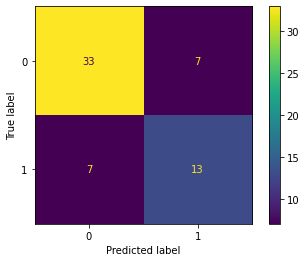

In [21]:
gs_svm, cf =apply_model(svm.SVC(random_state=SEED, probability=True), SVM_PARAMS,X_train,Y_train,X_test,Y_test)
print_grid_search_result(gs_svm)

In [22]:
cf

,predicted not death,predicted death
true not death,0.825,0.175
true death,0.350,0.650


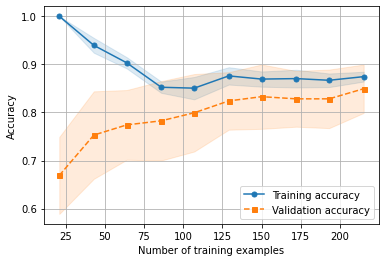

In [23]:
print_learning_curve(gs_svm.best_estimator_,X_train, Y_train)

## Configuration 2: Reduced dataset with PCA


Best grid scores on validation set:
0.752 (+/-0.136) for {'clf__C': 10, 'clf__kernel': 'linear'}


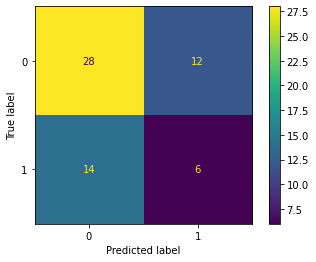

In [24]:
gs_svm_pca, cf_pca =apply_model(svm.SVC(random_state=SEED, probability=True), SVM_PARAMS,X_train_pca,Y_train,X_test,Y_test)
print_grid_search_result(gs_svm_pca)

In [25]:
cf_pca

,predicted not death,predicted death
true not death,0.7,0.3
true death,0.7,0.3


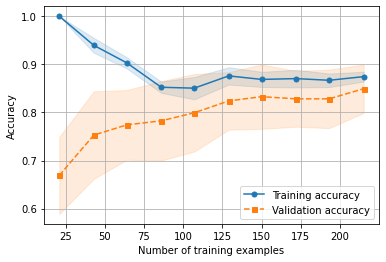

In [26]:
print_learning_curve(gs_svm_pca.best_estimator_,X_train_pca, Y_train)

## Configuration 3: Reduced dataset with undersampling


Best grid scores on validation set:
0.822 (+/-0.230) for {'clf__C': 1, 'clf__gamma': 0.1, 'clf__kernel': 'rbf'}


,predicted not death,predicted death
true not death,0.789,0.211
true death,0.250,0.750


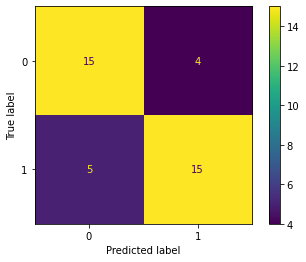

In [27]:
gs_svm_balanced, cf_svm_balanced =apply_model(svm.SVC(random_state=SEED, probability=True), SVM_PARAMS,X_train_balanced,Y_train_balanced,X_test_balanced,Y_test_balanced)
print_grid_search_result(gs_svm_balanced)
cf_svm_balanced

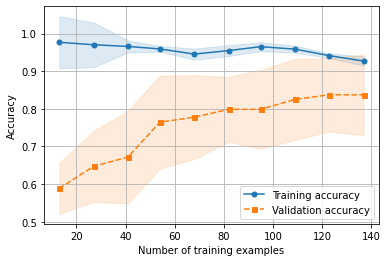

In [28]:
print_learning_curve(gs_svm_balanced.best_estimator_,X_train_balanced, Y_train_balanced)

## Configuration 4: SMOTE

smote
Best grid scores on validation set:
0.753 (+/-0.181) for {'clf__C': 100, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



,predicted not death,predicted death
true not death,0.675,0.325
true death,0.350,0.650


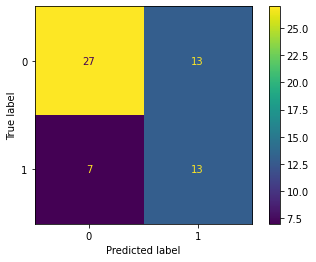

In [29]:
gs_svm_sm, cf_svm_sm =apply_model(svm.SVC(random_state=SEED, probability=True), SVM_PARAMS,X_train,Y_train,X_test,Y_test, smote=True)
print_grid_search_result(gs_svm_sm)
cf_svm_sm

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Expected n_neighbors <= n_samples,  but n_samples = 5, n_neighbors = 6


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: Futur

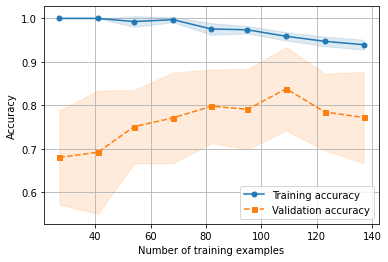

In [30]:
print_learning_curve(gs_svm_sm.best_estimator_,X_train_balanced, Y_train_balanced)

# Logistic regression

## Configuration 1: full dataset

In [31]:
LOGISTIC_REGRESSION_PARAMS = {
    'clf__solver': ['liblinear'],
    'clf__C': [0.1, 1, 10],
    'clf__penalty': ['l2', 'l1']
}

Best grid scores on validation set:
0.738 (+/-0.141) for {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}


,predicted not death,predicted death
true not death,0.725,0.275
true death,0.300,0.700


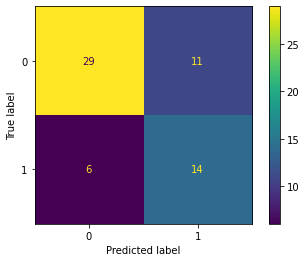

In [32]:
gs_lr, cf_lr =apply_model(LogisticRegression(random_state=SEED, class_weight="balanced"), LOGISTIC_REGRESSION_PARAMS,X_train,Y_train,X_test,Y_test)
print_grid_search_result(gs_lr)
cf_lr

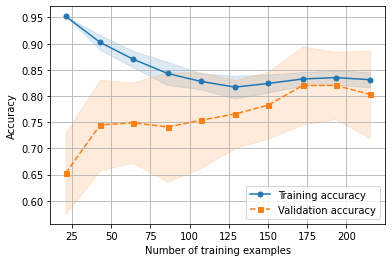

In [33]:
print_learning_curve(gs_lr.best_estimator_,X_train, Y_train)

## Configuration 2: Reduced dataset with PCA

Best grid scores on validation set:
0.738 (+/-0.141) for {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}


,predicted not death,predicted death
true not death,0.7,0.3
true death,0.3,0.7


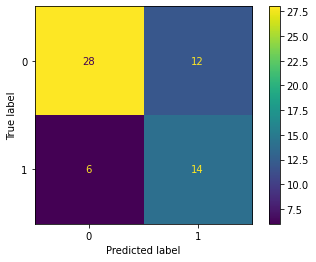

In [34]:
gs_lr_pca, cf_lr_pca =apply_model(LogisticRegression(random_state=SEED, class_weight="balanced"), LOGISTIC_REGRESSION_PARAMS,X_train_pca,Y_train,X_test_pca,Y_test)
print_grid_search_result(gs_lr_pca)
cf_lr_pca

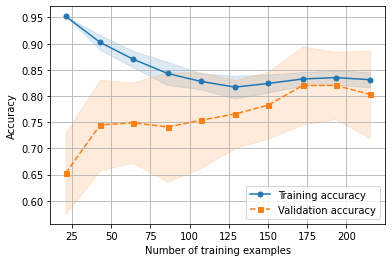

In [35]:
print_learning_curve(gs_lr_pca.best_estimator_,X_train, Y_train)

## Configuration 3: Reduced dataset with undersampling

Best grid scores on validation set:
0.786 (+/-0.185) for {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}


,predicted not death,predicted death
true not death,0.789,0.211
true death,0.250,0.750


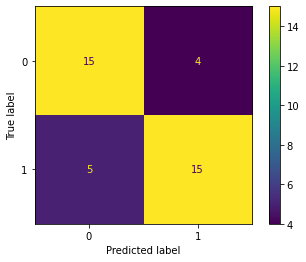

In [36]:
gs_lr_balanced, cf_lr_balanced =apply_model(LogisticRegression(random_state=SEED, class_weight="balanced"), LOGISTIC_REGRESSION_PARAMS,X_train_balanced,Y_train_balanced,X_test_balanced,Y_test_balanced)
print_grid_search_result(gs_lr_balanced)
cf_lr_balanced

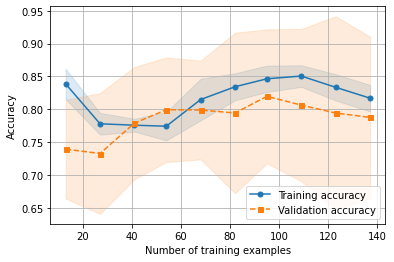

In [37]:
print_learning_curve(gs_lr_balanced.best_estimator_,X_train_balanced, Y_train_balanced)

## Configuration 4: SMOTE

smote
Best grid scores on validation set:
0.716 (+/-0.150) for {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



,predicted not death,predicted death
true not death,0.7,0.3
true death,0.3,0.7


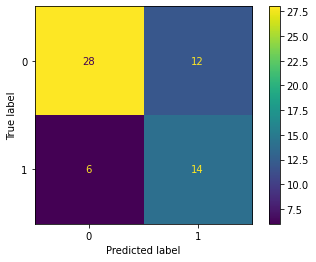

In [38]:
gs_lr_sm, cf_lr_sm =apply_model(LogisticRegression(random_state=SEED), LOGISTIC_REGRESSION_PARAMS,X_train,Y_train,X_test,Y_test,smote=True)
print_grid_search_result(gs_lr_sm)
cf_lr_sm

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.2

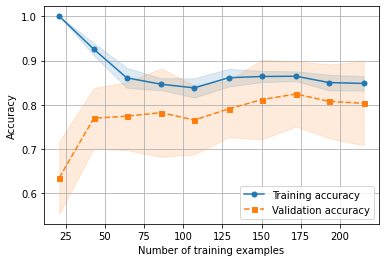

In [39]:
print_learning_curve(gs_lr_sm.best_estimator_,X_train, Y_train)

# KNN

## Configuration 1: full dataset

In [40]:
KNN_PARAMS = {
    'clf__n_neighbors': [5, 15, 25, 35, 45, 55, 65],
    'clf__weights': ['uniform', 'distance'],
    'clf__p': [1, 2, 10]
}
KNN_PARAMS_BAL = {
    'clf__n_neighbors': [5, 7, 9, 13],
    'clf__weights': ['uniform', 'distance'],
    'clf__p': [1, 2, 10]
}

Best grid scores on validation set:
0.474 (+/-0.210) for {'clf__n_neighbors': 5, 'clf__p': 1, 'clf__weights': 'uniform'}


,predicted not death,predicted death
true not death,0.95,0.05
true death,0.70,0.30


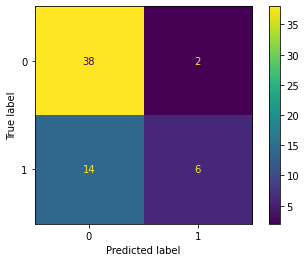

In [41]:
gs_knn, cf_knn =apply_model(KNeighborsClassifier(), KNN_PARAMS,X_train,Y_train,X_test,Y_test)
print_grid_search_result(gs_knn)
cf_knn

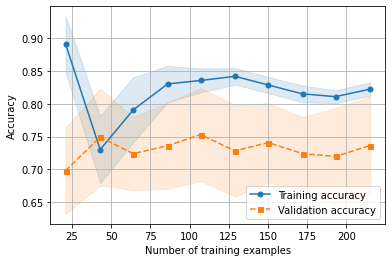

In [42]:
print_learning_curve(gs_knn.best_estimator_,X_train, Y_train)

## Configuration 2: Reduced dataset with PCA

Best grid scores on validation set:
0.477 (+/-0.207) for {'clf__n_neighbors': 9, 'clf__p': 10, 'clf__weights': 'distance'}


,predicted not death,predicted death
true not death,0.80,0.20
true death,0.75,0.25


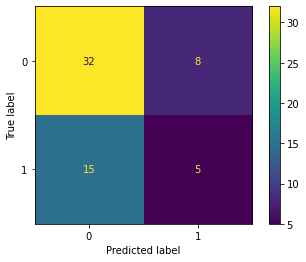

In [43]:
gs_knn_pca, cf_knn_pca =apply_model(KNeighborsClassifier(), KNN_PARAMS_BAL,X_train_pca,Y_train,X_test,Y_test)
print_grid_search_result(gs_knn_pca)
cf_knn_pca

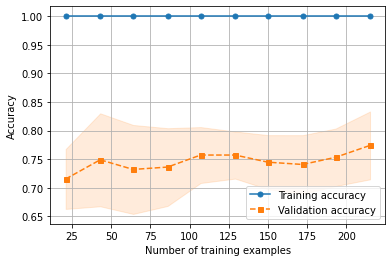

In [44]:
print_learning_curve(gs_knn_pca.best_estimator_,X_train_pca, Y_train)

## Configuration 3: Reduced dataset with undersampling

Best grid scores on validation set:
0.720 (+/-0.253) for {'clf__n_neighbors': 13, 'clf__p': 1, 'clf__weights': 'distance'}


,predicted not death,predicted death
true not death,0.895,0.105
true death,0.400,0.600


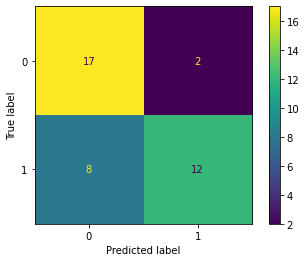

In [45]:
gs_knn_balanced, cf_knn_balanced = apply_model(KNeighborsClassifier(), KNN_PARAMS_BAL,X_train_balanced,Y_train_balanced,X_test_balanced,Y_test_balanced)
print_grid_search_result(gs_knn_balanced)
cf_knn_balanced

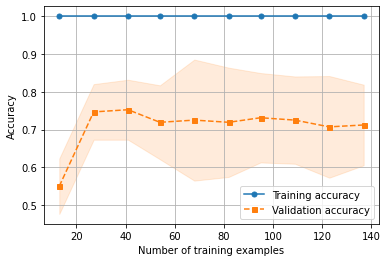

In [46]:
print_learning_curve(gs_knn_pca.best_estimator_,X_train_balanced, Y_train_balanced)

## Configuration 4: SMOTE

smote
Best grid scores on validation set:
0.628 (+/-0.156) for {'clf__n_neighbors': 9, 'clf__p': 2, 'clf__weights': 'uniform'}


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



,predicted not death,predicted death
true not death,0.60,0.40
true death,0.35,0.65


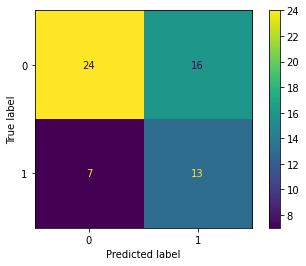

In [47]:
gs_knn_sm, cf_knn_sm = apply_model(KNeighborsClassifier(), KNN_PARAMS_BAL,X_train,Y_train,X_test,Y_test, smote=True)
print_grid_search_result(gs_knn_sm)
cf_knn_sm

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.2

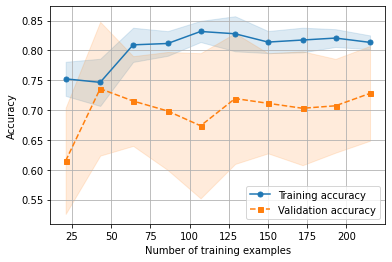

In [48]:
print_learning_curve(gs_knn_sm.best_estimator_,X_train, Y_train)

#Decision Tree

In [49]:
DECISION_TREE_PARAMS = {
    'clf__max_depth': [25, 50, 75],
    'clf__max_features': ["sqrt"], # just sqrt is used because values of log2 and sqrt are very similar for our number of features (10-19)
    'clf__criterion': ['gini', 'entropy'],
    'clf__min_samples_split': [6, 10, 14],
}

## Configuration 1: full dataset

Best grid scores on validation set:
0.674 (+/-0.316) for {'clf__criterion': 'entropy', 'clf__max_depth': 75, 'clf__max_features': 'sqrt', 'clf__min_samples_split': 14}


,predicted not death,predicted death
true not death,0.825,0.175
true death,0.250,0.750


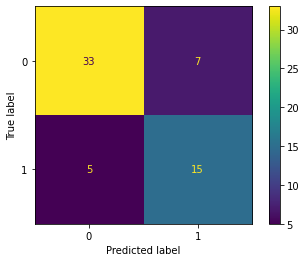

In [50]:
gs_dt, cf_dt =apply_model(DecisionTreeClassifier(random_state=SEED, class_weight="balanced"), DECISION_TREE_PARAMS, X_train, Y_train, X_test, Y_test)
print_grid_search_result(gs_dt)
cf_dt

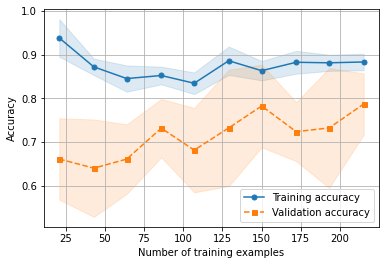

In [51]:
print_learning_curve(gs_dt.best_estimator_,X_train, Y_train)

In [52]:
def plot_feature_importance(feature_importance, title):
  fig_feat=go.Figure()
  fig_feat.add_trace(go.Bar(x=feature_importance[:,0],
                y=feature_importance[:,1],
                marker=dict(color=colors[0]),
                name='feature importance'
                ))
  
  fig_feat.update_layout(go.Layout(
        title=title,
        autosize=True,
        margin=go.layout.Margin(l=50, r=100, b=150),
        xaxis=dict(
            title='feature',
            tickangle=30
        ),
        yaxis=dict(
            title='feature importance',
            automargin=True,
        ),
    ),  font=dict(size=18))
  fig_feat.show()


In [53]:
feature_importance = np.array(sorted(zip(X_train.columns, gs_dt.best_estimator_.named_steps['clf'].feature_importances_), key=lambda x: x[1], reverse=True))
plot_feature_importance(feature_importance, "Feature importance in the decision tree")

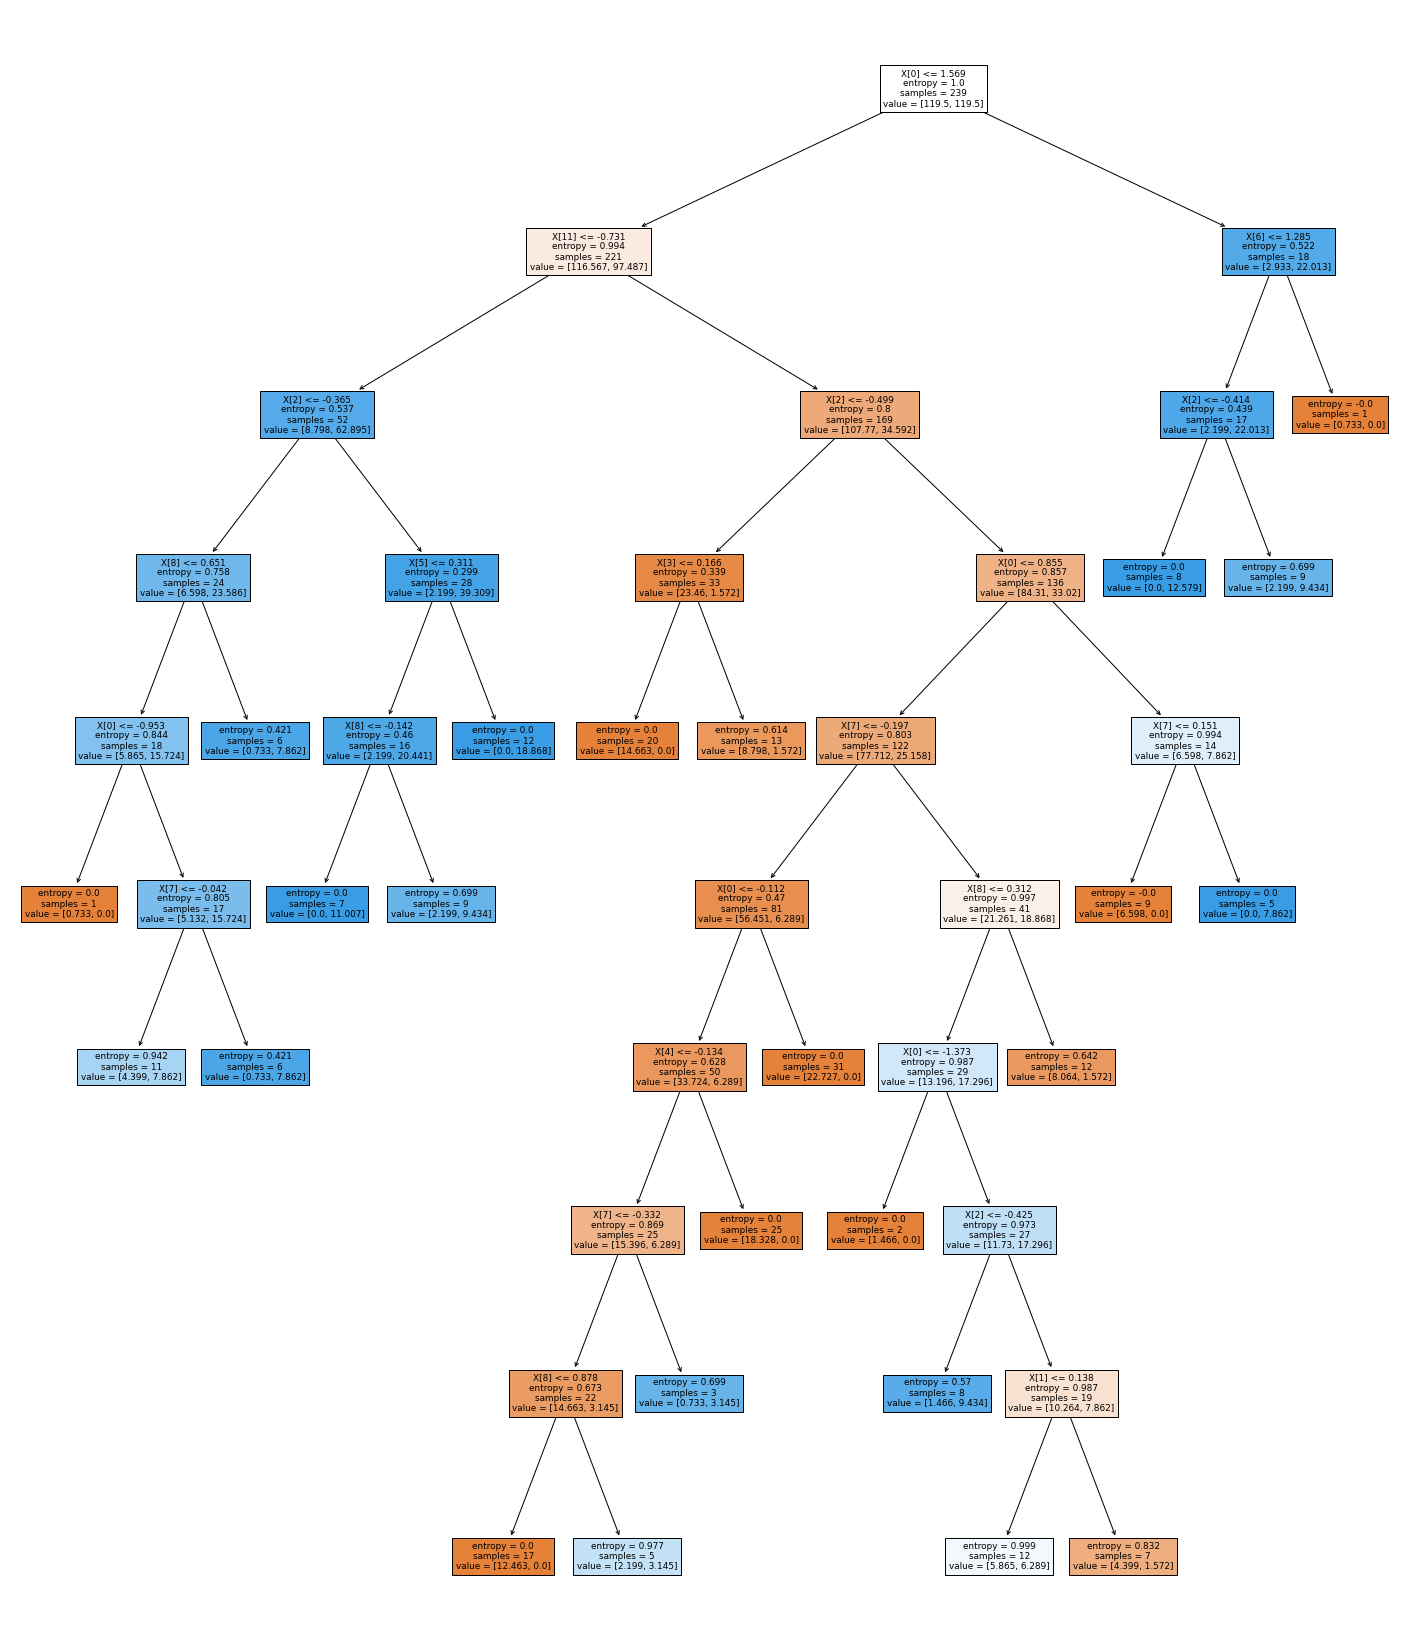

In [54]:
plt.figure(figsize=(25,30))
plot_tree(gs_dt.best_estimator_[0], filled=True)
plt.show()

## Configuration 2: Reduced dataset with PCA

Best grid scores on validation set:
0.596 (+/-0.161) for {'clf__criterion': 'entropy', 'clf__max_depth': 75, 'clf__max_features': 'sqrt', 'clf__min_samples_split': 14}


,predicted not death,predicted death
true not death,0.625,0.375
true death,0.250,0.750


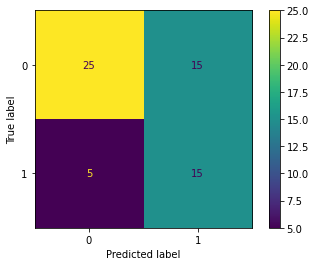

In [55]:
gs_dt_pca, cf_dt_pca =apply_model(DecisionTreeClassifier(random_state=SEED, class_weight="balanced"), DECISION_TREE_PARAMS, X_train_pca, Y_train, X_test_pca, Y_test)
print_grid_search_result(gs_dt_pca)
cf_dt_pca

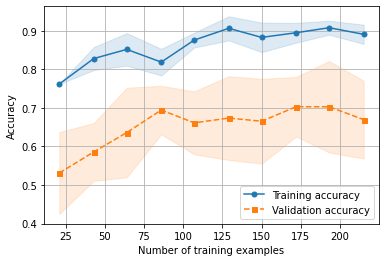

In [56]:
print_learning_curve(gs_dt.best_estimator_,X_train_pca, Y_train)

In [57]:
#does it have sense?
#feature_importance = np.array(sorted(zip(X_train_pca, gs_dt_pca.best_estimator_.named_steps['clf'].feature_importances_), key=lambda x: x[1], reverse=True))
#plot_feature_importance(feature_importance, "Feature importance in the decision tree")

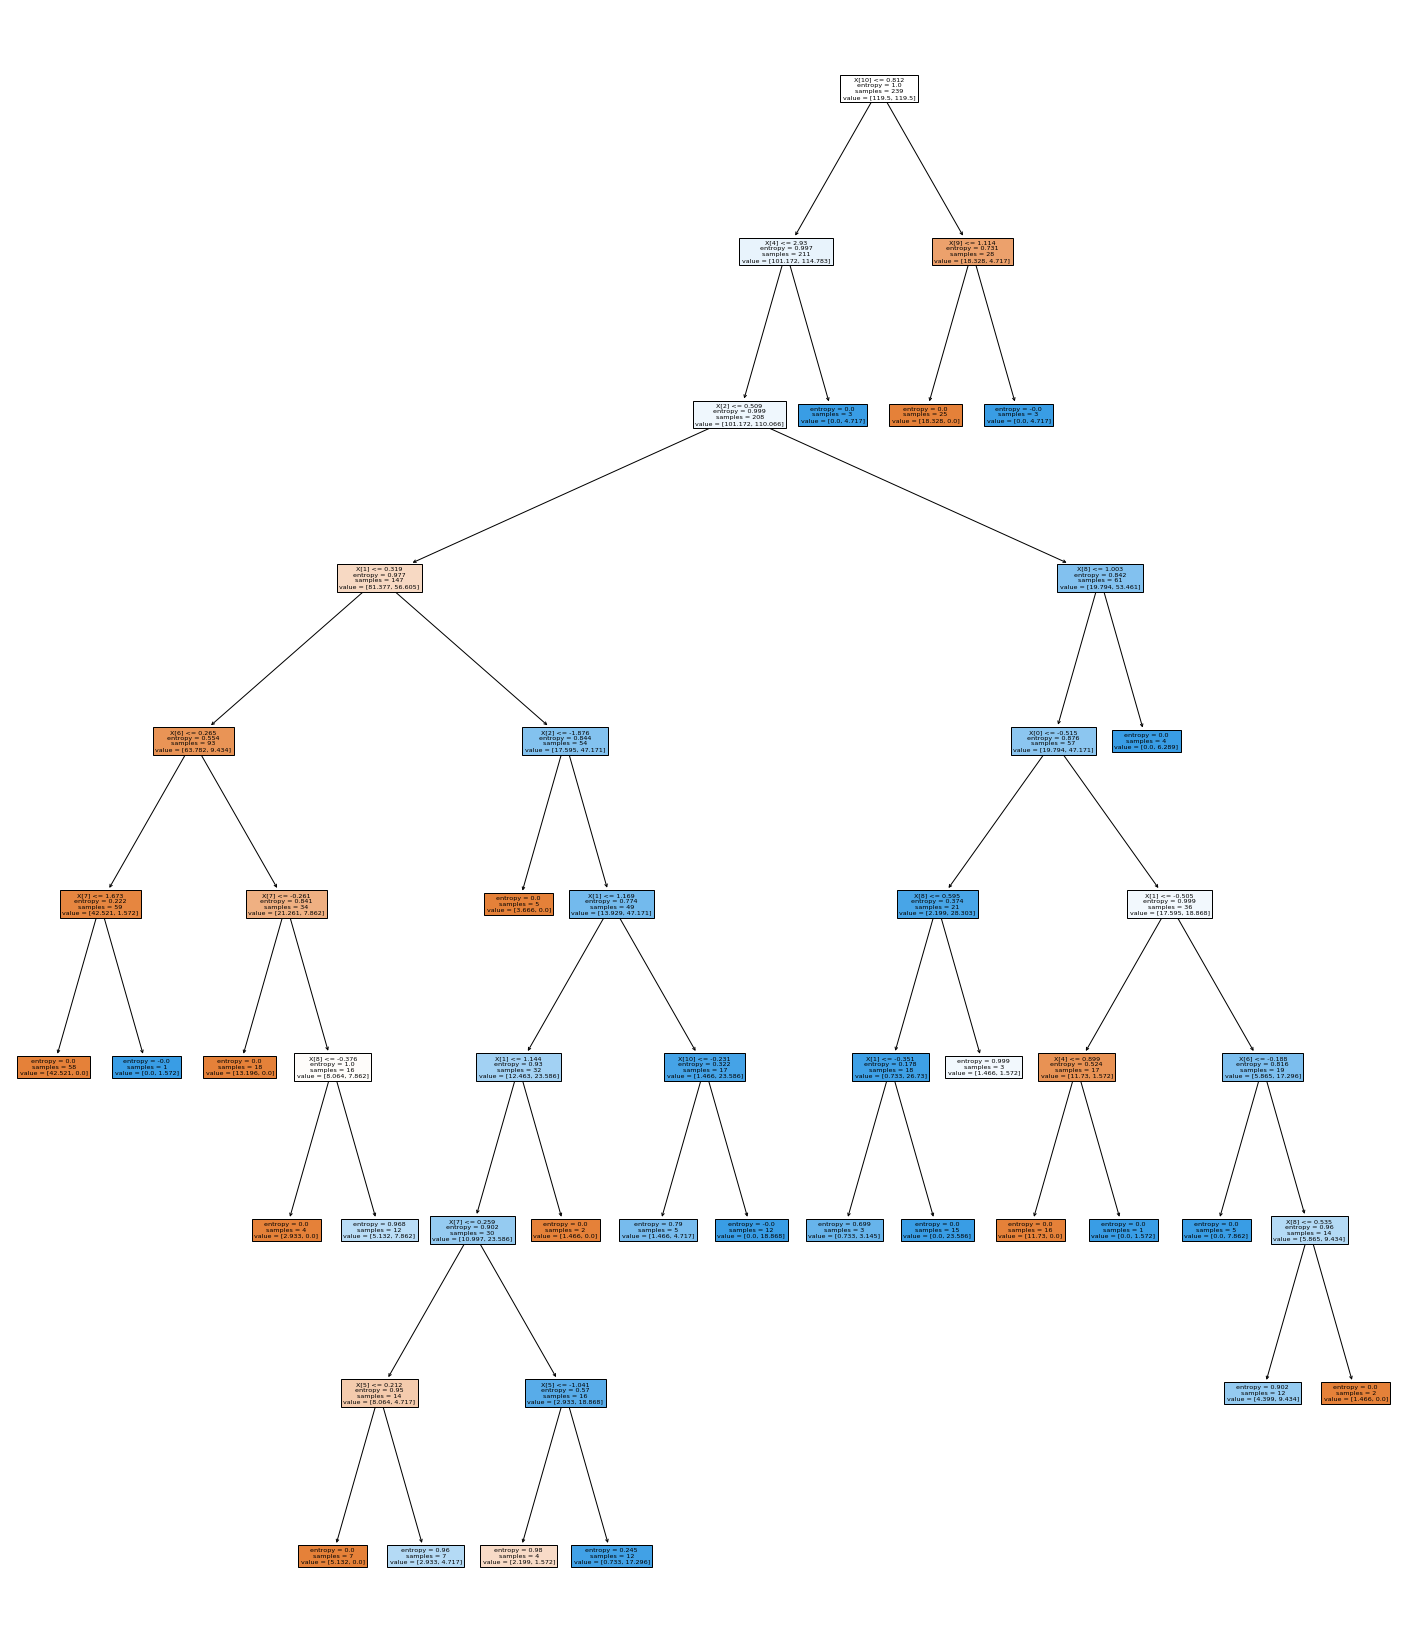

In [58]:
plt.figure(figsize=(25,30))
plot_tree(gs_dt_pca.best_estimator_[0], filled=True)
plt.show()

## Configuration 3: Reduced dataset with undersampling

Best grid scores on validation set:
0.756 (+/-0.132) for {'clf__criterion': 'gini', 'clf__max_depth': 75, 'clf__max_features': 'sqrt', 'clf__min_samples_split': 14}


,predicted not death,predicted death
true not death,0.632,0.368
true death,0.250,0.750


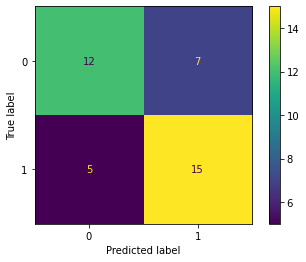

In [59]:
gs_dt_balanced, cf_dt_balanced =apply_model(DecisionTreeClassifier(random_state=SEED), DECISION_TREE_PARAMS, X_train_balanced, Y_train_balanced, X_test_balanced, Y_test_balanced)
print_grid_search_result(gs_dt_balanced)
cf_dt_balanced

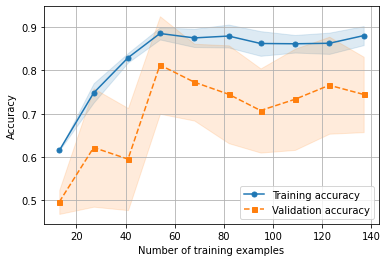

In [60]:
print_learning_curve(gs_dt_balanced.best_estimator_,X_train_balanced, Y_train_balanced)

In [61]:
feature_importance = np.array(sorted(zip(X_train.columns, gs_dt_balanced.best_estimator_.named_steps['clf'].feature_importances_), key=lambda x: x[1], reverse=True))
plot_feature_importance(feature_importance, "Feature importance in the decision tree")

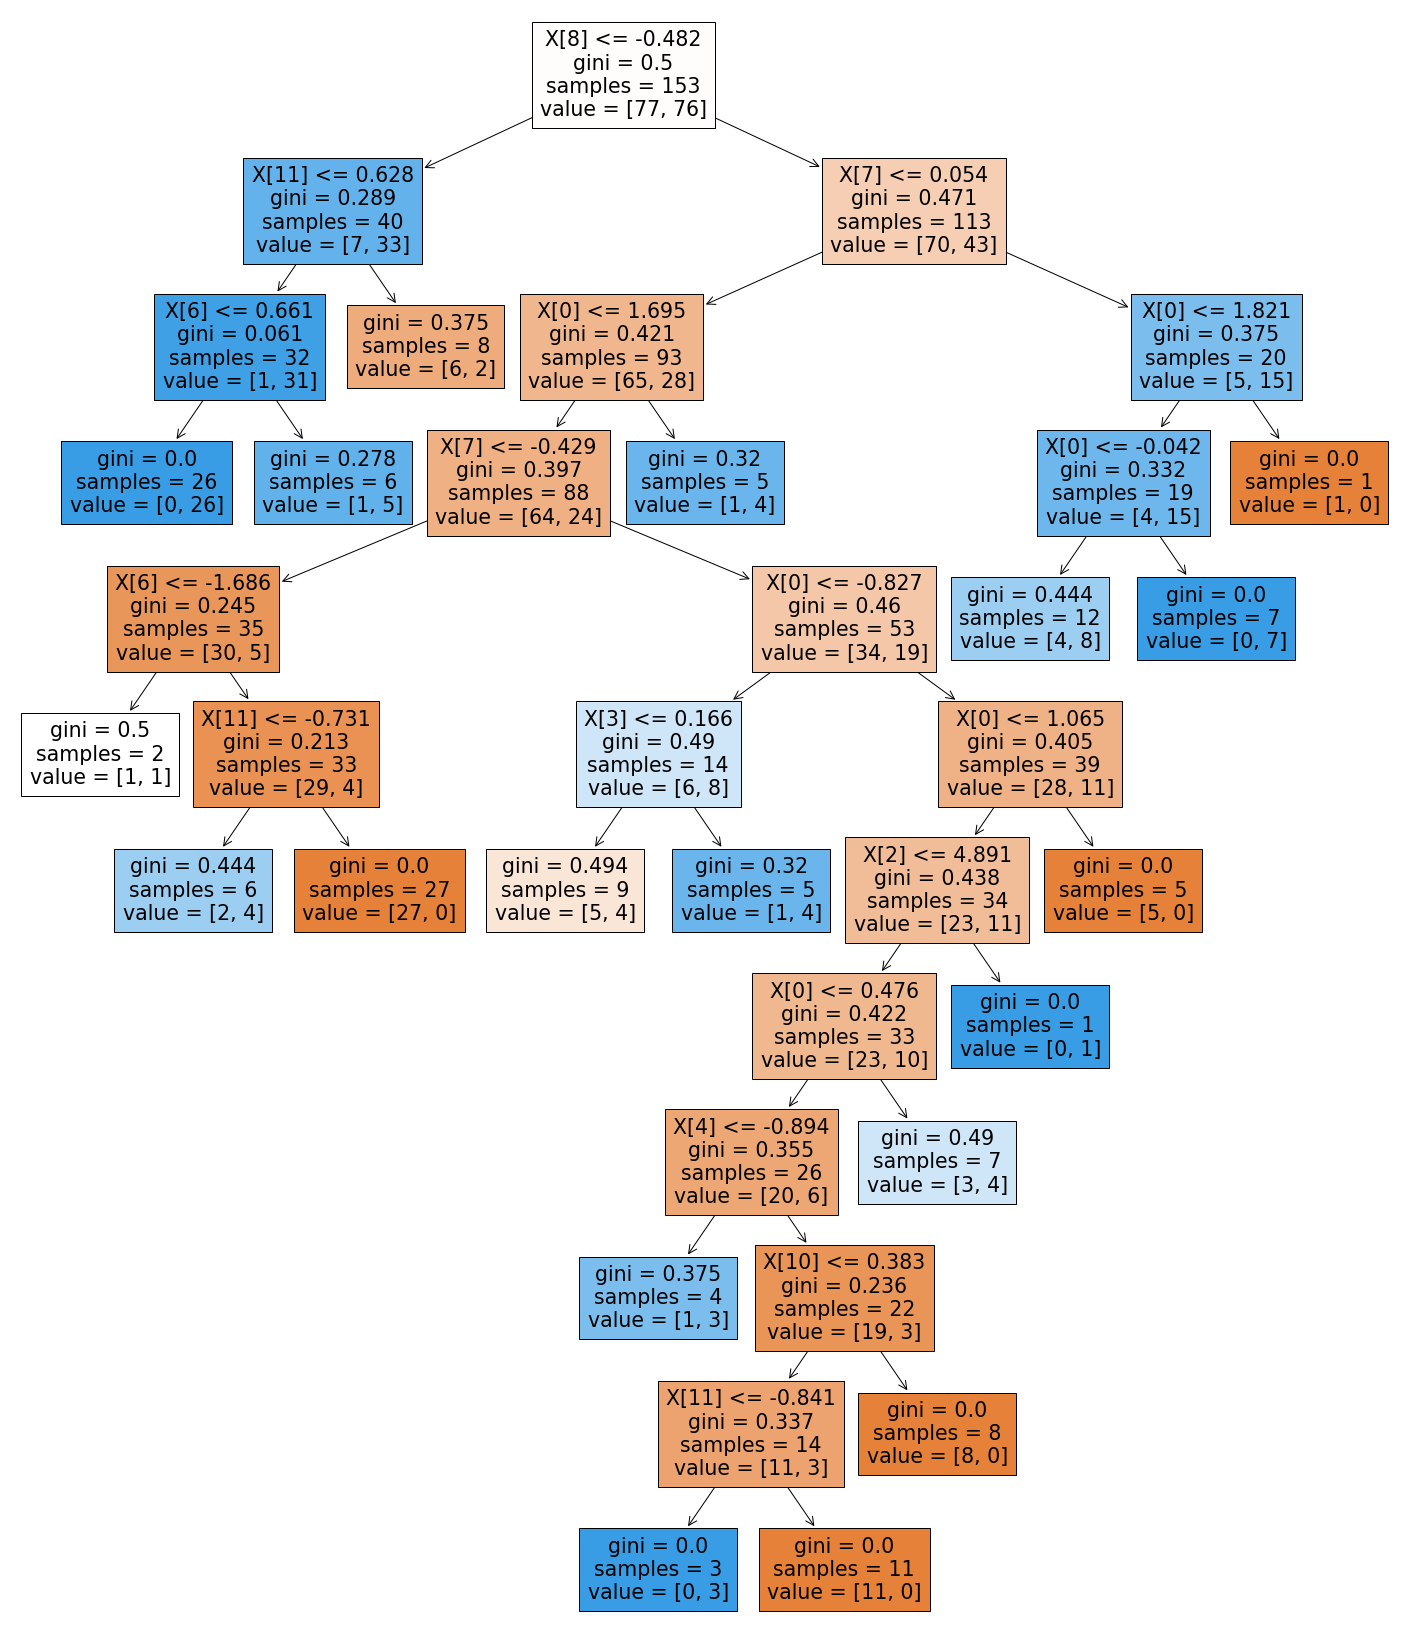

In [62]:
plt.figure(figsize=(25,30))
plot_tree(gs_dt_balanced.best_estimator_[0], filled=True)
plt.show()

## Configuration 4: SMOTE

smote
Best grid scores on validation set:
0.616 (+/-0.292) for {'clf__criterion': 'gini', 'clf__max_depth': 25, 'clf__max_features': 'sqrt', 'clf__min_samples_split': 6}


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



,predicted not death,predicted death
true not death,0.825,0.175
true death,0.250,0.750


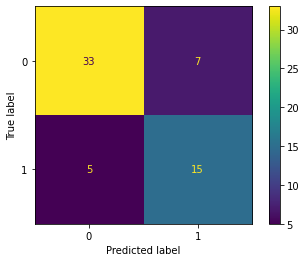

In [63]:
gs_dt_sm, cf_dt_sm =apply_model(DecisionTreeClassifier(random_state=SEED), DECISION_TREE_PARAMS, X_train, Y_train, X_test, Y_test, smote=True)
print_grid_search_result(gs_dt_sm)
cf_dt_sm

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.2

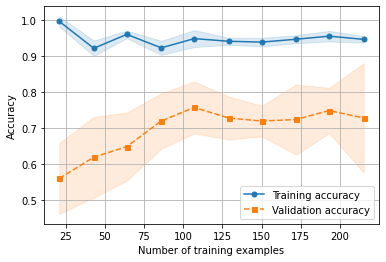

In [64]:
print_learning_curve(gs_dt_sm.best_estimator_,X_train, Y_train)

In [65]:
feature_importance = np.array(sorted(zip(X_train.columns, gs_dt_sm.best_estimator_.named_steps['clf'].feature_importances_), key=lambda x: x[1], reverse=True))
plot_feature_importance(feature_importance, "Feature importance in the decision tree")

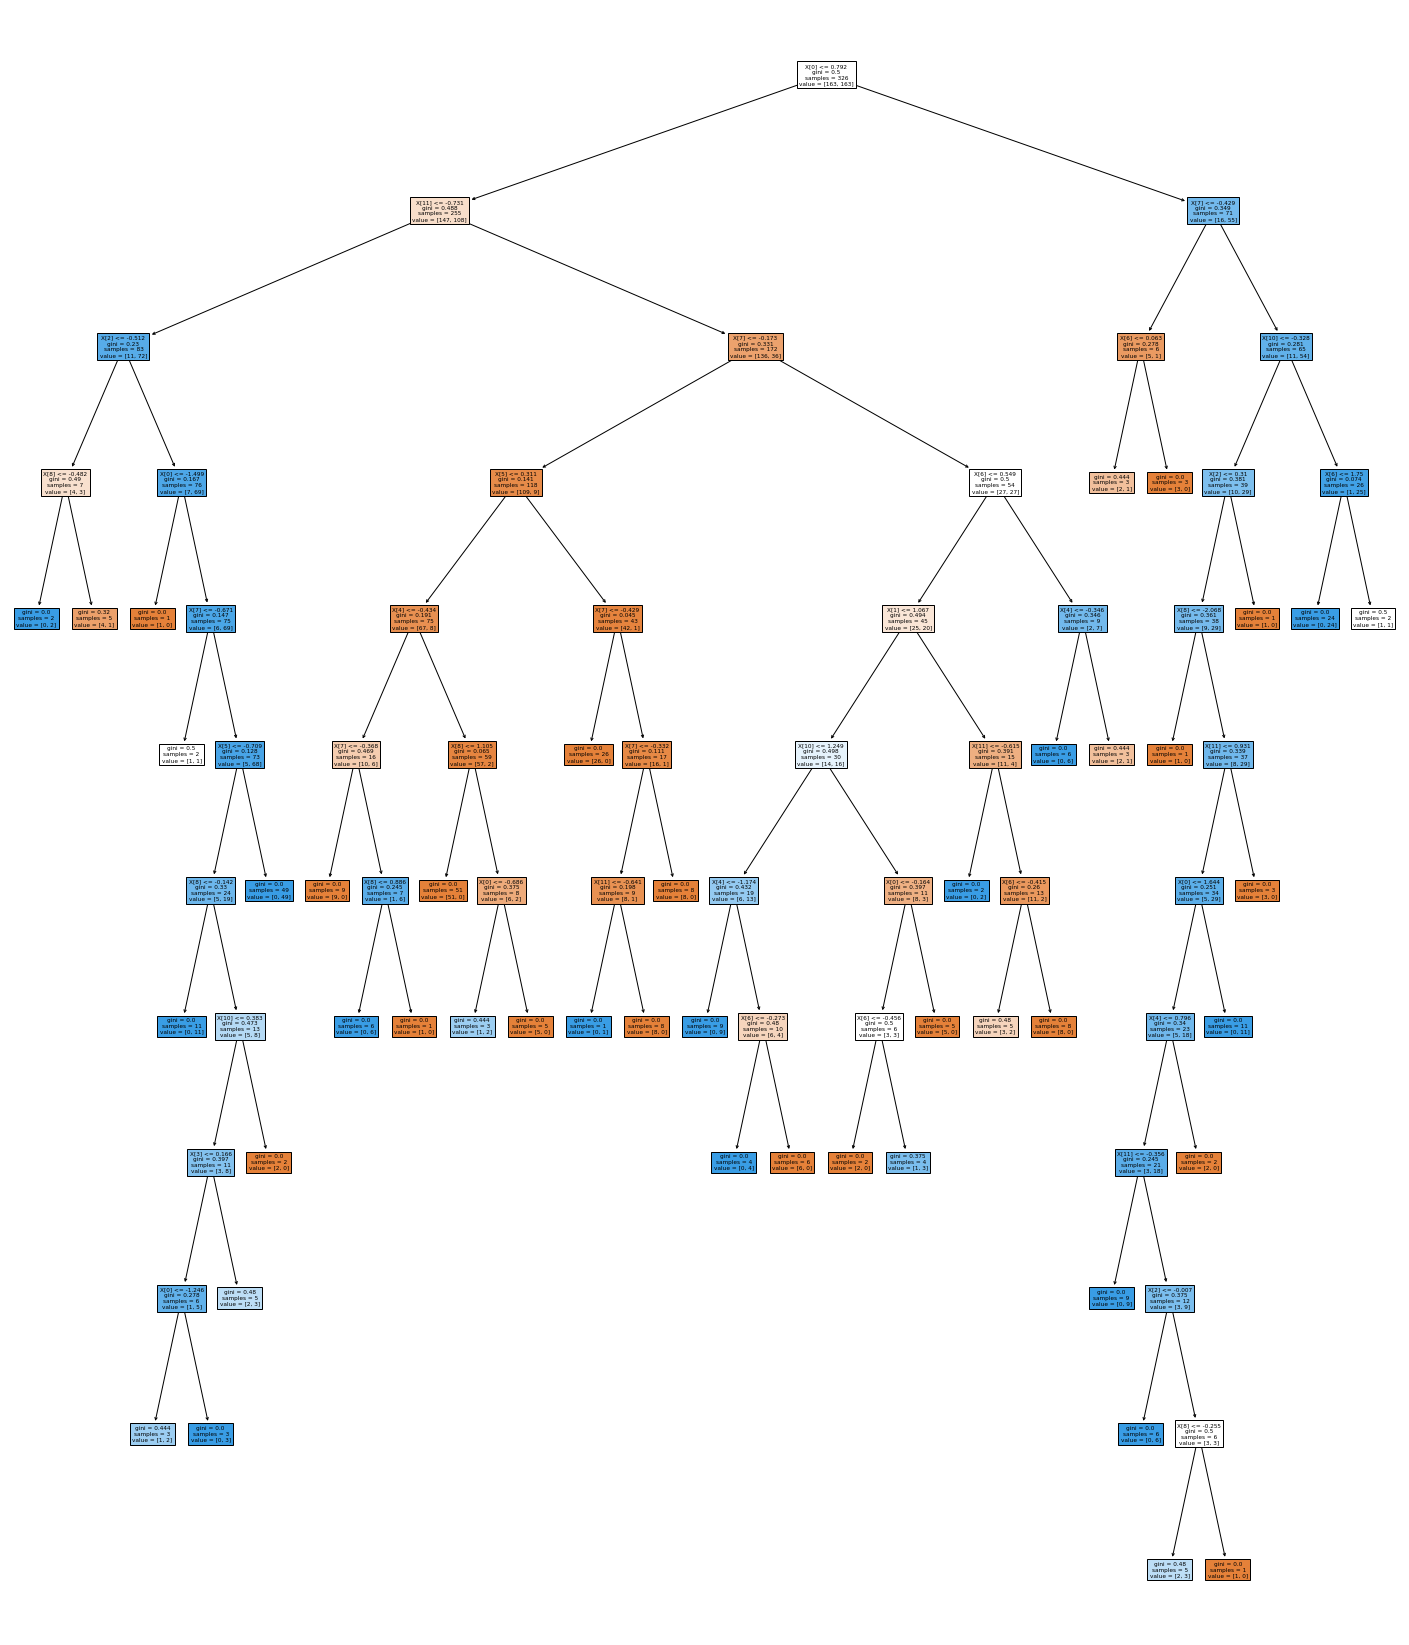

In [66]:
plt.figure(figsize=(25,30))
plot_tree(gs_dt_sm.best_estimator_[1], filled=True)
plt.show()

# Random forest

In [67]:
RANDOM_FOREST_PARAMS = {
    'clf__max_depth': [25, 50, 75],
    'clf__max_features': ["sqrt"], # just sqrt is used because values of log2 and sqrt are very similar for our number of features (10-19) 
    'clf__criterion': ['gini', 'entropy'],
    'clf__n_estimators': [100, 300, 500, 1000]
}

## Configuration 1: full dataset

Best grid scores on validation set:
0.741 (+/-0.179) for {'clf__criterion': 'gini', 'clf__max_depth': 25, 'clf__max_features': 'sqrt', 'clf__n_estimators': 100}


,predicted not death,predicted death
true not death,0.95,0.05
true death,0.35,0.65


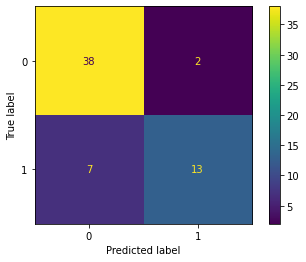

In [68]:
gs_rf, cf_rf = apply_model(RandomForestClassifier(random_state=SEED, class_weight="balanced"), RANDOM_FOREST_PARAMS, X_train, Y_train, X_test, Y_test)
print_grid_search_result(gs_rf)
cf_rf

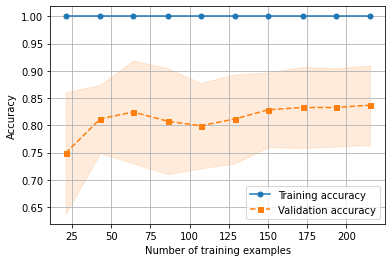

In [69]:
print_learning_curve(gs_rf.best_estimator_,X_train, Y_train)

In [70]:
feature_importance = np.array(sorted(zip(X_train.columns, gs_rf.best_estimator_.named_steps['clf'].feature_importances_), key=lambda x: x[1], reverse=True))
plot_feature_importance(feature_importance, "Feature importance in the decision tree")

## Configuration 2: Reduced dataset with PCA

Best grid scores on validation set:
0.560 (+/-0.132) for {'clf__criterion': 'entropy', 'clf__max_depth': 75, 'clf__max_features': 'sqrt', 'clf__n_estimators': 100}


,predicted not death,predicted death
true not death,0.85,0.15
true death,0.40,0.60


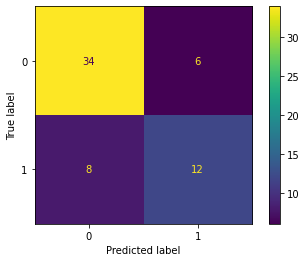

In [71]:
gs_rf_pca, cf_rf_pca = apply_model(RandomForestClassifier(random_state=SEED, class_weight="balanced"), RANDOM_FOREST_PARAMS, X_train_pca, Y_train, X_test_pca, Y_test)
print_grid_search_result(gs_rf_pca)
cf_rf_pca

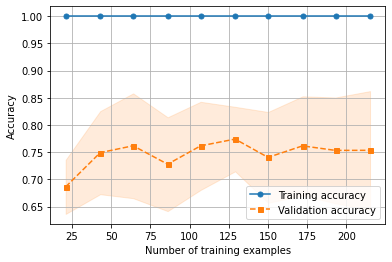

In [72]:
print_learning_curve(gs_rf_pca.best_estimator_,X_train_pca, Y_train)

In [73]:
#feature_importance = np.array(sorted(zip(X_train_pca, gs_rf_pca.best_estimator_.named_steps['clf'].feature_importances_), key=lambda x: x[1], reverse=True))
#plot_feature_importance(feature_importance, "Feature importance in the decision tree")

## Configuration 3: Reduced dataset with undersampling

Best grid scores on validation set:
0.848 (+/-0.158) for {'clf__criterion': 'gini', 'clf__max_depth': 25, 'clf__max_features': 'sqrt', 'clf__n_estimators': 300}


,predicted not death,predicted death
true not death,0.737,0.263
true death,0.200,0.800


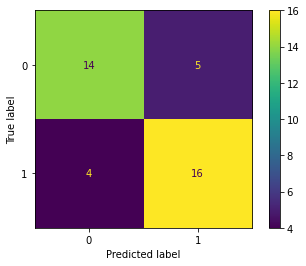

In [74]:
gs_rf_balanced, cf_rf_balanced = apply_model(RandomForestClassifier(random_state=SEED), RANDOM_FOREST_PARAMS, X_train_balanced, Y_train_balanced, X_test_balanced, Y_test_balanced)
print_grid_search_result(gs_rf_balanced)
cf_rf_balanced

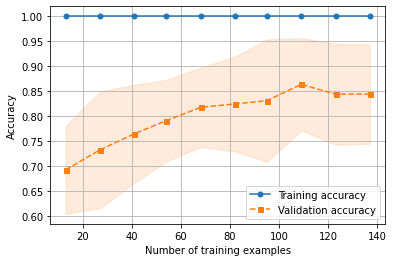

In [75]:
print_learning_curve(gs_rf_balanced.best_estimator_,X_train_balanced, Y_train_balanced)

In [76]:
feature_importance = np.array(sorted(zip(X_train_balanced.columns, gs_rf_balanced.best_estimator_.named_steps['clf'].feature_importances_), key=lambda x: x[1], reverse=True))
plot_feature_importance(feature_importance, "Feature importance in the decision tree")

## Configuration 4: SMOTE

smote


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



Best grid scores on validation set:
0.779 (+/-0.166) for {'clf__criterion': 'gini', 'clf__max_depth': 75, 'clf__max_features': 'sqrt', 'clf__n_estimators': 1000}


,predicted not death,predicted death
true not death,0.90,0.10
true death,0.35,0.65


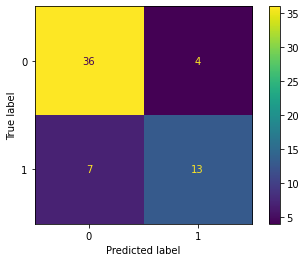

In [77]:
gs_rf_sm, cf_rf_sm = apply_model(RandomForestClassifier(random_state=SEED), RANDOM_FOREST_PARAMS, X_train, Y_train, X_test, Y_test, smote=True)
print_grid_search_result(gs_rf_sm)
cf_rf_sm

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.2

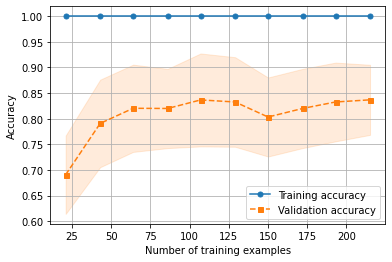

In [78]:
print_learning_curve(gs_rf_sm.best_estimator_,X_train, Y_train)

In [79]:
feature_importance = np.array(sorted(zip(X_train.columns, gs_rf_sm.best_estimator_.named_steps['clf'].feature_importances_), key=lambda x: x[1], reverse=True))
plot_feature_importance(feature_importance, "Feature importance in the decision tree")

# ROC Curve

In [80]:
# code partially from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
def plot_roc_curve(classifiers, legend, title, X_test, y_test):
    fig_ROC=go.Figure()
    fig_ROC.add_trace(go.Scatter(
        x=[0, 1], 
        y=[0, 1], 
        showlegend=False,
        mode="lines",
        name="",
        line = dict(
            color = colors[0],
        ),
    ))
    
    
    aucs = []
    for clf, string, c in zip(classifiers, legend, colors[1:]):
        y_test_roc = np.array([([0, 1] if y else [1, 0]) for y in y_test])
        y_score = clf.predict_proba(X_test)
        
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(2):
            fpr[i], tpr[i], _ = roc_curve(y_test_roc[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test_roc.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        aucs.append(roc_auc['micro'])

        fig_ROC.add_trace(go.Scatter(
            x=fpr['micro'], 
            y=tpr['micro'], 
            showlegend=True,
            mode="lines",
            name=string + " (area = %0.2f)" % roc_auc['micro'],
            hoverlabel = dict(
                namelength=30
            ),
            line = dict(
                color = c,
            ),
        ))

    layout = go.Layout(
        title=title,
        autosize=False,
        width=550,
        height=550,
        yaxis=dict(
            title='True Positive Rate',
        ),
        xaxis=dict(
            title="False Positive Rate",
        ),
        legend=dict(
            x=0.4,
            y=0.06,
        ),
    )
    fig_ROC.update_layout(layout,height=900, width=900,  font=dict(size=20))
    fig_ROC.show()
    return aucs


classifier_names = ["Logistic Regression", "KNN", "SVM", "Decision Tree", "Random Forest"]

## Configuration 1: full dataset

In [81]:
classifiers = [gs_lr, gs_knn, gs_svm, gs_dt, gs_rf]
auc_scores = plot_roc_curve(classifiers, classifier_names, "ROC curve", X_test, Y_test)


## Configuration 2: Reduced dataset with PCA

In [82]:
classifiers_pca = [gs_lr_pca, gs_knn_pca, gs_svm_pca, gs_dt_pca, gs_rf_pca]
auc_scores_pca = plot_roc_curve(classifiers_pca, classifier_names, "ROC curve", X_test_pca, Y_test)


##Configuration 3: Reduced dataset with undersampling


In [83]:
classifiers_balanced = [gs_lr_balanced, gs_knn_balanced, gs_svm_balanced, gs_dt_balanced, gs_rf_balanced]
auc_scores_balanced = plot_roc_curve(classifiers_balanced, classifier_names, "ROC curve", X_test_balanced, Y_test_balanced)


## Configuration 4: SMOTE

In [84]:
classifiers_sm = [gs_lr_sm, gs_knn_sm, gs_svm_sm, gs_dt_sm, gs_rf_sm]
auc_scores_sm = plot_roc_curve(classifiers_balanced, classifier_names, "ROC curve", X_test, Y_test)

# Comparison
Compare accuracy, precision, recall and f1-score on test set for each classifier

In [85]:
def compare_classifiers( classifiers, auc_scores, X_test, y_test, classifier_names=classifier_names):
  accs = []
  recalls = []
  precision = []
  results_table = pd.DataFrame(columns=["accuracy", "precision", "recall", "f1", "auc"])
  for (i, clf), name, auc in zip(enumerate(classifiers), classifier_names, auc_scores):
      y_pred = clf.predict(X_test)
      row = []
      row.append(accuracy_score(y_test, y_pred))
      row.append(precision_score(y_test, y_pred))
      row.append(recall_score(y_test, y_pred))
      row.append(f1_score(y_test, y_pred))
      row.append(auc)
      row = ["%.3f" % r for r in row]
      results_table.loc[name] = row
  return results_table

## Configuration 1: full dataset

In [86]:
results_1=compare_classifiers(classifiers,auc_scores, X_test, Y_test)
results_1

,accuracy,precision,recall,f1,auc
Logistic Regression,0.717,0.560,0.700,0.622,0.802
KNN,0.733,0.750,0.300,0.429,0.776
SVM,0.767,0.650,0.650,0.650,0.809
Decision Tree,0.800,0.682,0.750,0.714,0.892
Random Forest,0.850,0.867,0.650,0.743,0.899


## Configuration 2: Reduced Dataset with PCA

In [87]:
results_2=compare_classifiers(classifiers_pca,auc_scores_pca, X_test_pca, Y_test)
results_2

,accuracy,precision,recall,f1,auc
Logistic Regression,0.700,0.538,0.700,0.609,0.801
KNN,0.767,0.800,0.400,0.533,0.793
SVM,0.767,0.650,0.650,0.650,0.809
Decision Tree,0.667,0.500,0.750,0.600,0.700
Random Forest,0.767,0.667,0.600,0.632,0.838


##Configuration 3: Reduced dataset with undersampling

In [88]:
results_3=compare_classifiers(classifiers_balanced,auc_scores_balanced, X_test_balanced, Y_test_balanced)
results_3

,accuracy,precision,recall,f1,auc
Logistic Regression,0.769,0.789,0.750,0.769,0.842
KNN,0.744,0.857,0.600,0.706,0.838
SVM,0.769,0.789,0.750,0.769,0.877
Decision Tree,0.692,0.682,0.750,0.714,0.676
Random Forest,0.769,0.762,0.800,0.780,0.896


## Configuration 4: SMOTE

In [89]:
results_4=compare_classifiers(classifiers_sm,auc_scores_sm, X_test, Y_test)
results_4

,accuracy,precision,recall,f1,auc
Logistic Regression,0.700,0.538,0.700,0.609,0.845
KNN,0.617,0.448,0.650,0.531,0.977
SVM,0.667,0.500,0.650,0.565,0.898
Decision Tree,0.800,0.682,0.750,0.714,0.814
Random Forest,0.817,0.765,0.650,0.703,0.979


# Observations and Conclusions

- Configuration 1 (entire dataset): The best model is the Random Forest, that has the best scores in almost all metrics.
- Configuration 2 (reduced dataset with PCA): The best models are the Random Forest, SVM and KNN, as we have
already seen from the ROC curves. In particular, Random Forest and SVM have the best scores in the appropriate
metrics for our problem: F1-score and AUC.
- Configuration 3 (reduced dataset with undersampling): The metrics replicate the ROC curves trends. In particular, we
can see that KNN works very good in this configuration because of the balancing of the two classes.
- Configuration 4 (SMOTE): The best models are the Random Forest and Decision Tree. The AUC scores are, in general,
very high for every model.
Looking purely at metrics, it seems that Random Forest is one of the best model for every configuration, even if we have seen
that there is overfitting. Furthermore, for the dataset reduced with undersampling, the KNN works very good: this shows that
the KNN is sensible to unbalancing

Looking at all our results, we can say that, for the prediction of death of patients
-  Even if the follow-up time feature is not a clinical feature, it has an huge importance in classification. In the features’
correlation matrix we have observed a negative correlation between time and death and in both Decision Tree and
Random Fores it is the most important feature used to classify samples.
- The PCA is not useful in this case: we have no improvements using it
- The unbalancing of the two classes is an issue, especially for KNN model. Indeed, the KNN works better in the 3-rd
configuration in which the balancing is reached by doing an under-sampling on the majority class.
- The best results are reached by Random Forest model, even if it overfits on the data.In particular, the best AUC score
is in the 4th configuration in which we balance the two classes using the SMOTE approach.
-  Considering all the configurations, the best one is the 4th, that uses SMOTE. It leads to very good performance (with Random Forest we have the highest AUC) and all the models, also KNN, works well using it. This because the SMOTE technique solves the unbalancing adding samples in the dataset, instead of reducing them. Indeed, a cause of overfitting is the low amount of training data, so in general is not good to reduce samples as we did in configuration 3. So, this configuration surely helps the models to not overfit and to be more able to generalize. At the end, it seems to be the configuration more stable for all the models. 